In [1]:
# Тюнинг
import optuna as opt
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_selection import RFE

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from imblearn.over_sampling import SMOTE

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, SplineTransformer, PowerTransformer, PolynomialFeatures, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessClassifier

%matplotlib inline

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
test_df = pd.read_csv(TEST_DATASET)

# Сбалансированный (ТОЛЬКО ДЛЯ САБМИТА)
# balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
# train_df = balanced_df

# Выравнивание
# first_negatives = train_df[train_df['y'] == 0][:train_df[train_df['y'] == 1]['y'].count()]
# train_df = pd.concat([train_df[train_df['y'] == 1], first_negatives])

# Нормализация всего тренировочного (ТОЛЬКО ДЛЯ САБМИТА)
# train_df = train_df[train_df['Длительность'] < 400]
# train_df = train_df[(train_df['Сумма'] > 2) & (train_df['Сумма'] < 10)]
# train_df = train_df[train_df['До поставки'] < 300]
# train_df = train_df[train_df['Дней между 0_1'] < 400]
# train_df = train_df[train_df['Количество изменений после согласований'] < 2000]
# train_df = train_df[train_df['Количество'] < 300000]

X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Нормализация для кв/тестов
X_train = pd.concat([X_train, y_train], axis=1)

X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [3]:
# Категориальные фичи
cat_features_cat = [
    'Purchasing Organization', 
    'Company Code', 'Provider', 
    'Provider Purchaser', 'Operations Manager', 
    'Material Group', 'Factory',
    'Purchasing Group', 'EI', 'Weekday'
    ]

cat_features_lgbm = [
    'Purchasing Organization', 
    'Company Code', 'Provider', 
    'Provider Purchaser', 'Operations Manager', 'Sum Fold',
    'Material Group',
    'Purchasing Group', 'EI', 
    ]

# Фичи на масштабирование
scale_features = [
    'Position Count', 'Duration', 'ETC Delivery',
    'Changes After Approvals', 'Order Approval 1', 'Order Approval 2',
    'Order Approval 3', 'Sum', 'Change Delivery Date 7', 'Change Delivery Date 15', 
    'Change Delivery Date 30', 'Approval Cycles',
    'Handlers 7', 'Handlers 15', 'Handlers 30',
    'Days Between 0_1', 'Days Between 1_2', 'Days Between 2_3', 
    'Days Between 3_4', 'Days Between 4_5',
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8',
    'ETC Difference', 'ETC Power'
]

# Фичи на дроп
drop_features = [
    'Material', 'Cancel Complete Release', 'Month1', 'Month2', 'Month3',
    'Delivery Date', 'Change on Paper', 'Amount',
    'Category Manager', 'NRP', 'Provider Delivery option'
    ]

# Новые имена фич
rename_cols = [
    'Provider', 'Material', 'Category Manager', 'Operations Manager',
    'Factory', 'Purchasing Organization', 'Purchasing Group', 
    'Company Code', 'EI', 'Material Group', 'Delivery Option', 'NRP',
    'Duration', 'ETC Delivery', 'Month1', 'Month2', 'Month3', 'Weekday',
    'Sum', 'Position Count', 'Amount', 'Handlers 7', 'Handlers 15', 
    'Handlers 30', 'Order Approval 1', 'Order Approval 2', 'Order Approval 3',
    'Change Delivery Date 7', 'Change Delivery Date 15', 'Change Delivery Date 30',
    'Cancel Complete Release', 'Change on Paper', 'Delivery Date', 
    'Approval Cycles', 'Changes After Approvals', 'Days Between 0_1', 
    'Days Between 1_2', 'Days Between 2_3', 'Days Between 3_4', 'Days Between 4_5', 
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8'
    ]

In [4]:
# Препроцессоры
class DataPreprocessorCat(BaseEstimator, TransformerMixin):
    """ Предобработчик данных """
    def __init__(self, cat_features, scale_features,
                 drop_features, rename_cols, transform_train=True):
        self.transform_train = transform_train
        self.cat_features = cat_features

        self.robust_scaler = RobustScaler()

        self.rename_cols = rename_cols

        self.drop_features = drop_features
        self.scale_features = scale_features

    def fit(self, X, y=None):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols
        
        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2
        
        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        self.robust_scaler.fit(X_[self.scale_features])

        X_ = X_.drop(self.drop_features, axis=1)
        
        return self
    
    def transform(self, X):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2

        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        X_[self.scale_features] = self.robust_scaler.transform(X_[self.scale_features])

        X_ = X_.drop(self.drop_features, axis=1)

        return X_

In [5]:
# Препроцессоры
class DataPreprocessorLGBM(BaseEstimator, TransformerMixin):
    """ Предобработчик данных """
    def __init__(self, cat_features, scale_features,
                 drop_features, rename_cols, transform_train=True):
        self.transform_train = transform_train
        self.cat_features = cat_features

        self.bin_encoder = BinaryEncoder(cols=cat_features)
        self.robust_scaler = RobustScaler()

        self.rename_cols = rename_cols

        self.drop_features = drop_features
        self.scale_features = scale_features

    def fit(self, X, y=None):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols
        
        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2
        
        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        self.robust_scaler.fit(X_[self.scale_features])
        # Категориальные фичи        
        X_ = self.bin_encoder.fit_transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)
        
        return self
    
    def transform(self, X):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2

        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        X_[self.scale_features] = self.robust_scaler.transform(X_[self.scale_features])

        # Категориальные фичи
        X_ = self.bin_encoder.transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)

        return X_

In [6]:
# Функция оптимизации
def objective(trial: opt.Trial):
    # Параметры
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    iterations = trial.suggest_int('iterations', 300, 1000)
    max_depth = trial.suggest_int('max_depth', 4, 12)
    reg_lambda = trial.suggest_float('l2_leaf_reg', 0.1, 1)

    # Модель
    data_preprocessor = DataPreprocessorCat(cat_features, scale_features, drop_features, rename_cols)
    model = CatBoostClassifier(
        cat_features=cat_features,
        learning_rate=learning_rate,
        iterations=iterations,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        # auto_class_weights='Balanced'
    )

    pipeline = Pipeline([
        ('data_preproc', data_preprocessor),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
    accuracy = cv_score.mean()

    return accuracy

In [ ]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [72]:
sm = SMOTE(k_neighbors=5, random_state=0)
X_res, y_res = sm.fit_resample(X_train, y_train)
best_params_cat = {
    'cat_features': cat_features_cat,
    'learning_rate': 0.25,
    'iterations': 2000,
    'max_depth': 14,
    'num_leaves': 160,
    'l2_leaf_reg': 0.15,
    # 'auto_class_weights': 'Balanced',
    'task_type': 'GPU',
    'grow_policy': 'Lossguide'
}

In [73]:
data_preprocessor = DataPreprocessorCat(cat_features_cat, scale_features, drop_features, rename_cols)
model_cat = CatBoostClassifier(**best_params_cat, eval_metric='F1')
pipeline_cat = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model_cat)
])

pipeline_cat.fit(X_res, y_res, model__plot=True)
preds_cat = pipeline_cat.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8850910	total: 102ms	remaining: 3m 24s
1:	learn: 0.8999980	total: 195ms	remaining: 3m 14s
2:	learn: 0.9079260	total: 292ms	remaining: 3m 14s
3:	learn: 0.9130646	total: 389ms	remaining: 3m 14s
4:	learn: 0.9175105	total: 483ms	remaining: 3m 12s
5:	learn: 0.9213612	total: 574ms	remaining: 3m 10s
6:	learn: 0.9250927	total: 665ms	remaining: 3m 9s
7:	learn: 0.9302155	total: 751ms	remaining: 3m 6s
8:	learn: 0.9343415	total: 843ms	remaining: 3m 6s
9:	learn: 0.9367662	total: 935ms	remaining: 3m 6s
10:	learn: 0.9410881	total: 1.02s	remaining: 3m 5s
11:	learn: 0.9424475	total: 1.11s	remaining: 3m 4s
12:	learn: 0.9436186	total: 1.21s	remaining: 3m 4s
13:	learn: 0.9451685	total: 1.29s	remaining: 3m 3s
14:	learn: 0.9468698	total: 1.38s	remaining: 3m 2s
15:	learn: 0.9478936	total: 1.46s	remaining: 3m 1s
16:	learn: 0.9488237	total: 1.55s	remaining: 3m
17:	learn: 0.9498943	total: 1.63s	remaining: 2m 59s
18:	learn: 0.9509466	total: 1.72s	remaining: 2m 59s
19:	learn: 0.9516635	total: 1.82s	re

In [75]:
print(f1_score(y_test, preds_cat, average='macro'))
print(roc_auc_score(y_test, preds_cat))

0.8991708535815282
0.8880457965679641


              precision    recall  f1-score   support

           0    0.96638   0.97735   0.97183     18850
           1    0.85628   0.79874   0.82651      3185

    accuracy                        0.95153     22035
   macro avg    0.91133   0.88805   0.89917     22035
weighted avg    0.95046   0.95153   0.95083     22035



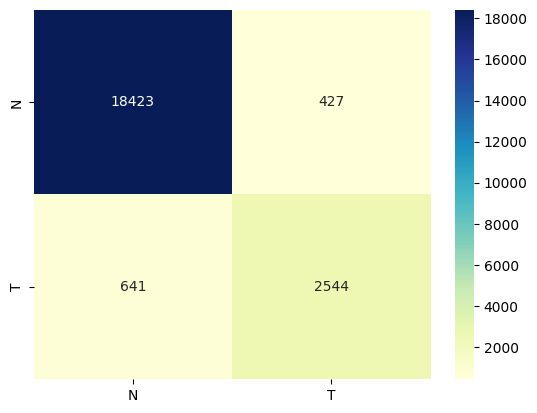

In [76]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds_cat) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds_cat, digits=5))

In [100]:
data_preprocessor = DataPreprocessorCat(cat_features_cat, scale_features, drop_features, rename_cols)
model_cat_1 = CatBoostClassifier(cat_features=cat_features_cat, eval_metric='F1')
pipeline_cat_1 = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model_cat_1)
])

pipeline_cat_1.fit(X_res, y_res, model__plot=True)
preds_cat_1 = pipeline_cat_1.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123907
0:	learn: 0.8467237	total: 214ms	remaining: 3m 34s
1:	learn: 0.8501705	total: 466ms	remaining: 3m 52s
2:	learn: 0.8674793	total: 698ms	remaining: 3m 52s
3:	learn: 0.8789315	total: 942ms	remaining: 3m 54s
4:	learn: 0.8866432	total: 1.15s	remaining: 3m 48s
5:	learn: 0.8899515	total: 1.3s	remaining: 3m 36s
6:	learn: 0.8960347	total: 1.57s	remaining: 3m 43s
7:	learn: 0.9001744	total: 1.84s	remaining: 3m 48s
8:	learn: 0.9029581	total: 2.08s	remaining: 3m 49s
9:	learn: 0.9064467	total: 2.3s	remaining: 3m 48s
10:	learn: 0.9073482	total: 2.6s	remaining: 3m 53s
11:	learn: 0.9087918	total: 2.85s	remaining: 3m 54s
12:	learn: 0.9122240	total: 3.13s	remaining: 3m 57s
13:	learn: 0.9137658	total: 3.4s	remaining: 3m 59s
14:	learn: 0.9136934	total: 3.6s	remaining: 3m 56s
15:	learn: 0.9147331	total: 3.87s	remaining: 3m 58s
16:	learn: 0.9166525	total: 4.08s	remaining: 3m 56s
17:	learn: 0.9178947	total: 4.29s	remaining: 3m 53s
18:	learn: 0.9180473	total: 4.53s	remaining: 3m 5

In [15]:
sm = SMOTE(k_neighbors=7, random_state=0)
X_res, y_res = sm.fit_resample(X_train, y_train)
best_params_lgbm = {
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 32, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Модель
data_preprocessor_lgbm = DataPreprocessorLGBM(cat_features_lgbm, scale_features, drop_features, rename_cols)
model_lgbm = LGBMClassifier(
    **best_params_lgbm,
    n_jobs=-1,
    force_col_wise=True,
    # is_unbalance=True,
    objective='binary'
)

pipeline_lgbm = Pipeline([
    ('data_preproc', data_preprocessor_lgbm),
    ('model', model_lgbm)
])

In [16]:
pipeline_lgbm.fit(X_res, y_res)
preds_lgbm = pipeline_lgbm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 169286, number of negative: 169286
[LightGBM] [Info] Total Bins 3506
[LightGBM] [Info] Number of data points in the train set: 338572, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [17]:
print(f1_score(y_test, preds_lgbm, average='macro'))
print(roc_auc_score(y_test, preds_lgbm))

0.9021601647546933
0.8923109402912359


              precision    recall  f1-score   support

           0    0.96660   0.97634   0.97144     18850
           1    0.85109   0.80031   0.82492      3185

    accuracy                        0.95090     22035
   macro avg    0.90884   0.88833   0.89818     22035
weighted avg    0.94990   0.95090   0.95026     22035



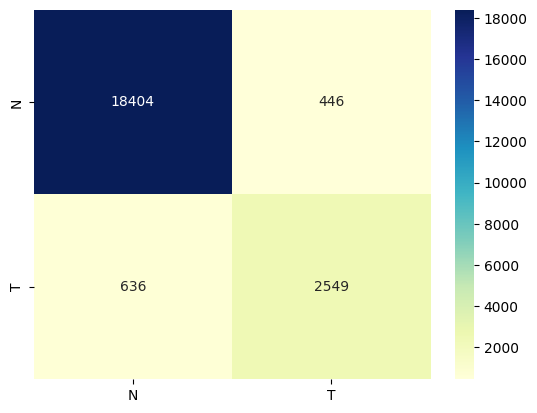

In [10]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds_lgbm) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds_lgbm, digits=5))

In [101]:
preds_lgbm = pipeline_lgbm.predict_proba(X_test)
preds_cat = pipeline_cat.predict_proba(X_test)
preds_cat_1 = pipeline_cat_1.predict_proba(X_test)

In [311]:
preds_blend = preds_cat * 0.1 + preds_lgbm * 0.8 + preds_cat_1 * 0.1
preds = [1 if pred[1] > 0.5 else 0 for pred in preds_blend]
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9010851473098602
0.8911059383965789


              precision    recall  f1-score   support

           0    0.96739   0.97719   0.97226     18850
           1    0.85638   0.80502   0.82991      3185

    accuracy                        0.95230     22035
   macro avg    0.91188   0.89111   0.90109     22035
weighted avg    0.95134   0.95230   0.95169     22035



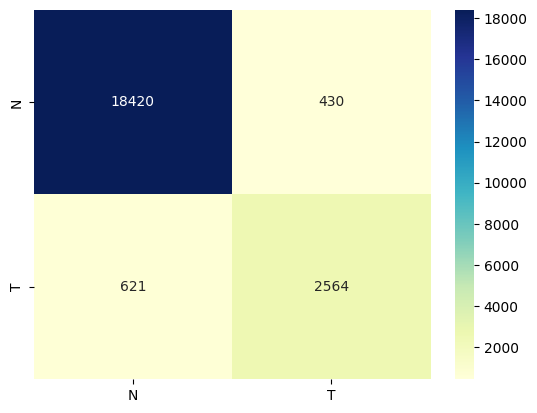

In [312]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

In [315]:
test = pd.concat([X_test, y_test], axis=1)
index = test[test['y'] != preds]

In [316]:
index

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,...,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y
5063,204,176,1,10,2,2,81,2,2,74,...,26,3.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
219891,2,27439,1,1,8,1,91,7,1,66,...,10,14.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
224238,333,4663,1,12,2,2,27,2,2,35,...,11,20.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
188486,773,27439,3,6,1,1,45,1,1,37,...,0,78.0,0.0,0.0,0.0,0.0,-1.0,-1.0,17.0,1
116680,303,590,2,2,1,1,172,1,8,26,...,20,-1.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110921,159,27439,2,3,7,1,63,6,1,79,...,0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,66.0,1
74490,532,27439,8,15,3,6,42,3,1,15,...,0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
183036,1,23143,1,1,1,1,46,1,1,4,...,0,7.0,0.0,2.0,1.0,0.0,-1.0,-1.0,8.0,1
85793,16,27439,4,5,1,1,100,1,1,1,...,17,6.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1


              precision    recall  f1-score   support

           0    0.97271   0.97204   0.97238     18850
           1    0.83521   0.83862   0.83691      3185

    accuracy                        0.95276     22035
   macro avg    0.90396   0.90533   0.90464     22035
weighted avg    0.95284   0.95276   0.95280     22035



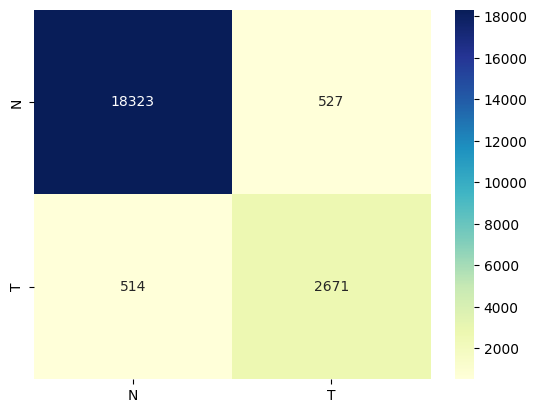

In [36]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

In [ ]:
save_submission(pipeline_cat, 'submission_cat')

In [ ]:
preds_cat = pd.DataFrame(preds)

In [ ]:
%store -r preds_lgbm
preds_lgbm = pd.DataFrame(preds_lgbm)

In [ ]:
res_df = pd.concat([preds_cat, preds_lgbm], axis=1)

In [ ]:
res_df

In [ ]:
res_df['equal'] = [1 if x == y else 0 for x, y in zip(res_df.iloc[:, 0].values, res_df.iloc[:, 1].values)]

In [ ]:
res_df['equal'].value_counts()

In [ ]:
preds = pipeline_cat.predict(X_test)
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))